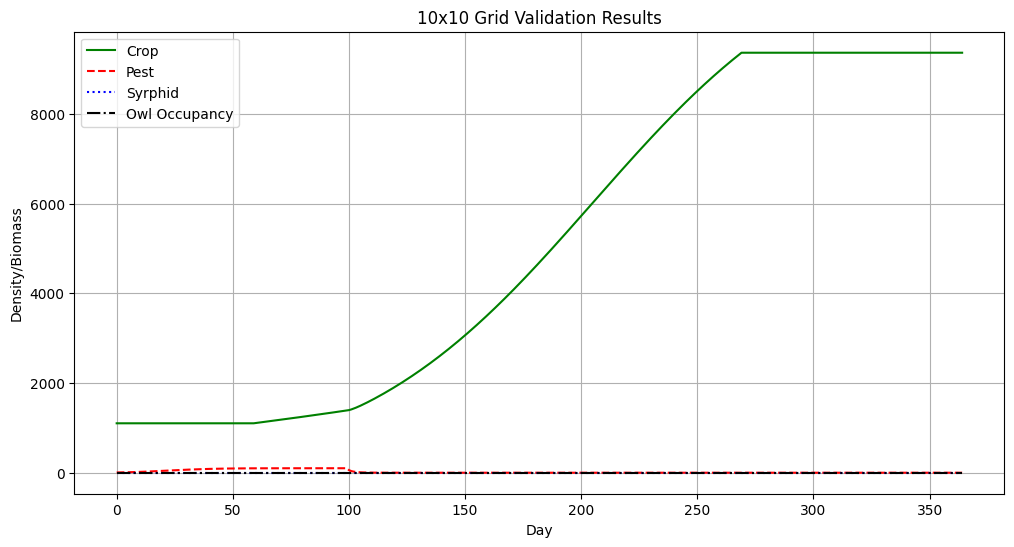

In [2]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from IPython.display import clear_output

# ================== 整合参数 ==================
class Parameters:
    def __init__(self):
        # 基础生态参数
        self.grid_size = 10           # 空间网格尺寸
        self.days = 365               # 模拟时长
        self.crop_max = 12000.0       # 最大作物生物量 (kg/ha)
        
        # 新增物种参数
        self.syrphid_disperse = 0.18  # 食蚜蝇扩散率
        self.syrphid_efficiency = 0.01 # 捕食效率
        self.owl_colonization = 0.06  # 林鸮定居率
        self.owl_extinction = 0.12    # 局域灭绝率
        
        # 杀虫剂参数
        self.pesticide_efficacy = 0.7 # 杀虫剂效率
        
        # 初始化随机种子
        np.random.seed(42)

params = Parameters()

# ================== 空间网格类 ==================
class AgriculturalGrid:
    def __init__(self):
        self.size = params.grid_size
        # 状态变量: [作物, 杂草, 害虫, 食蚜蝇, 土壤健康, 蝙蝠]
        self.grid = np.zeros((self.size, self.size, 6))
        
        # 初始化空间异质性
        self.grid[:,:,0] = np.random.lognormal(mean=7, sigma=0.3, size=(self.size, self.size))  # 作物
        self.grid[:,:,1] = np.random.poisson(lam=50, size=(self.size, self.size))               # 杂草
        self.grid[:,:,2] = np.random.exponential(scale=5, size=(self.size, self.size))          # 害虫
        self.grid[:,:,4] = 1.8 + np.random.rand(self.size, self.size)*0.5                       # 土壤
        self.grid[:,:,5] = np.random.poisson(lam=30, size=(self.size, self.size))               # 蝙蝠
        
    def apply_harvest(self, day):
        """ 收割事件 """
        if day == 270:
            self.grid[:,:,0] = 0  # 清除作物
            self.grid[:,:,2] *= 0.3  # 收割后害虫减少

# ================== 局域ODE模型 ==================
def local_ode(y, day):
    """ 单个元胞的生态动力学 """
    C, W, H, Sy, S, B = y
    p = pesticide_app(day)
    h = herbicide_app(day)
    
    # 作物动态
    if 60 <= day < 270:
        growth = 0.02 * C * (1 - C/params.crop_max)
        loss = 0.00012*H*C + 0.00005*h*C
        dC = growth - loss
    else:
        dC = 0
    
    # 杂草动态
    dW = 0.025*W*(1 - W/8000) - 0.006*h*W - 0.0003*C**0.7*W
    
    # 害虫动态
    dH = 0.15*H*(1 - H/100) - 0.002*B/1e6*H - params.pesticide_efficacy*p*H - 0.01*Sy*H
    
    # 食蚜蝇动态
    dSy = 0.0005*Sy*H/(H+10) - 0.001*Sy
    
    # 土壤动态
    dS = 0.00004*W - 0.0001*(h+p)*S - 0.00002*S
    
    # 蝙蝠动态
    dB = 0.0001*B*H/(H+10)*(0.5+0.5*np.cos(2*np.pi*(day-180)/365)) - (0.0005 + 0.002*p + 0.0005*h)*B
    
    return np.array([dC, dW, dH, dSy, dS, dB])

# ================== 空间交互模块 ==================
def syrphid_dispersal(grid):
    """ 食蚜蝇空间扩散 """
    kernel = np.array([[0.05, 0.2, 0.05],
                       [0.2,  0.1, 0.2],
                       [0.05, 0.2, 0.05]])
    new_syrphid = ndimage.convolve(grid[:,:,3], kernel, mode='reflect')
    grid[:,:,3] = grid[:,:,3]*0.7 + new_syrphid*params.syrphid_disperse
    return grid

class OwlMetapopulation:
    """ 林鸮元种群模型 """
    def __init__(self, grid):
        self.patches = self.detect_habitat(grid)
        
    def detect_habitat(self, grid):
        """ 检测边缘带栖息地 """
        edge_mask = (grid[:,:,0] == 0) & (grid[:,:,1] > 10)
        labeled, num = ndimage.label(edge_mask)
        return [{'cells': np.argwhere(labeled == i+1), 
                 'occupancy': 0.3} for i in range(num)]
    
    def update(self, pest_grid, grid):
        """ 更新栖息地占据率 """
        for patch in self.patches:
            pest_level = np.mean(pest_grid[tuple(patch['cells'].T)])
            colonize = params.owl_colonization * pest_level/50
            extinct = params.owl_extinction * (1 - pest_level/80)
            
            patch['occupancy'] = (1 - extinct)*patch['occupancy'] + colonize*(1 - patch['occupancy'])
            
            # 捕食反馈
            grid[tuple(patch['cells'].T)][:,2] *= 0.85  # 减少害虫

# ================== 农药施用函数 ==================
def pesticide_app(day):
    if 100 <= day <= 140: return 0.6
    if 165 <= day <= 205: return 0.9
    if 230 <= day <= 270: return 0.4
    return 0.0

def herbicide_app(day):
    if 50 <= day <= 90: return 1.2
    if 130 <= day <= 170: return 0.8
    return 0.0

# ================== 模型验证函数 ==================
def validate_conservation(prev_grid, new_grid):
    """ 验证质量守恒 """
    delta = np.abs(new_grid - prev_grid).sum()
    assert delta < 1e5, f"质量不守恒！差异量: {delta:.2f}"

def check_boundary_values(grid):
    """ 检查边界合理性 """
    assert (grid[:,:,0] >= 0).all(), "作物生物量为负值！"
    assert (grid[:,:,2] <= 200).all(), "害虫密度异常！"

# ================== 主运行循环 ==================
def main_simulation():
    grid = AgriculturalGrid().grid
    owl_model = OwlMetapopulation(grid)
    results = []
    
    for day in range(params.days):
        prev_grid = grid.copy()
        
        # 局域ODE更新
        for i in range(params.grid_size):
            for j in range(params.grid_size):
                dy = local_ode(grid[i,j,:], day)
                grid[i,j,:] += dy * 1  # 时间步长1天
        
        # 全局事件
        AgriculturalGrid().apply_harvest(day)
        
        # 空间交互
        grid = syrphid_dispersal(grid)
        owl_model.update(grid[:,:,2], grid)
        
        # 验证检查
        validate_conservation(prev_grid, grid)
        check_boundary_values(grid)
        
        # 记录结果
        results.append({
            'day': day,
            'crop': grid[:,:,0].mean(),
            'pest': grid[:,:,2].mean(),
            'syrphid': grid[:,:,3].mean(),
            'owl_occ': np.mean([p['occupancy'] for p in owl_model.patches]) if owl_model.patches else 0
        })
        
        # 每30天可视化
        if day % 30 == 0:
            plot_spatial(grid, day)
            
    return results

# ================== 可视化函数 ==================
def plot_spatial(grid, day):
    clear_output(wait=True)
    plt.figure(figsize=(15,4))
    
    plt.subplot(141)
    plt.imshow(grid[:,:,0], cmap='YlGn', vmin=0, vmax=12000)
    plt.title(f'Day {day} Crop Biomass')
    
    plt.subplot(142)
    plt.imshow(grid[:,:,3], cmap='Greens', vmin=0, vmax=50)
    plt.title('Syrphid Density')
    
    plt.subplot(143)
    plt.imshow(grid[:,:,2], cmap='Reds', vmin=0, vmax=100)
    plt.title('Pest Density')
    
    plt.subplot(144)
    plt.imshow(grid[:,:,4], cmap='YlOrBr', vmin=1.5, vmax=3.0)
    plt.title('Soil Health')
    
    plt.tight_layout()
    plt.show()

# ================== 运行验证 ==================
if __name__ == '__main__':
    print("开始10×10网格验证...")
    results = main_simulation()
    
    # 绘制时间序列
    plt.figure(figsize=(12,6))
    plt.plot([r['day'] for r in results], [r['crop'] for r in results], 'g-', label='Crop')
    plt.plot([r['day'] for r in results], [r['pest'] for r in results], 'r--', label='Pest')
    plt.plot([r['day'] for r in results], [r['syrphid'] for r in results], 'b:', label='Syrphid')
    plt.plot([r['day'] for r in results], [r['owl_occ'] for r in results], 'k-.', label='Owl Occupancy')
    plt.xlabel('Day')
    plt.ylabel('Density/Biomass')
    plt.legend()
    plt.title('10x10 Grid Validation Results')
    plt.grid(True)
    plt.show()